In [23]:
import pandas as pd 
import seaborn as sns 
import sqlite3
import numpy as np
from plotly import express as px
with sqlite3.connect("../tickets.db") as conn: 
    cmd = \
        """
        SELECT g.*, e.price, e.extractTime, e.ticket_count FROM extraction e
        LEFT JOIN games g on e.id = g.id
        """
    df = pd.read_sql_query(cmd, conn)

# convert
df['time'], df['extractTime'] = pd.to_datetime(df['time']), pd.to_datetime(df['extractTime'])
df = df.dropna().sort_values("extractTime") # remove empty rows and entries that did not have entries and ensure sorting by extractTime
df

,id,time,name,homeTeam,awayTeam,unique_name,price,extractTime,ticket_count
0,104722879.0,2021-06-11,Texas Rangers at Los Angeles Dodgers,Los Angeles Dodgers,Texas Rangers,Texas Rangers at Los Angeles Dodgers: 2021-06-11,58.62,2021-06-08 17:51:48.284897,0
22,104725435.0,2021-08-03,Houston Astros at Los Angeles Dodgers,Los Angeles Dodgers,Houston Astros,Houston Astros at Los Angeles Dodgers: 2021-08-03,110.02,2021-06-08 17:51:48.284897,0
21,104724585.0,2021-07-25,Colorado Rockies at Los Angeles Dodgers,Los Angeles Dodgers,Colorado Rockies,Colorado Rockies at Los Angeles Dodgers: 2021-...,33.92,2021-06-08 17:51:48.284897,0
20,104724583.0,2021-07-24,Colorado Rockies at Los Angeles Dodgers,Los Angeles Dodgers,Colorado Rockies,Colorado Rockies at Los Angeles Dodgers: 2021-...,38.83,2021-06-08 17:51:48.284897,0
19,104724581.0,2021-07-23,Colorado Rockies at Los Angeles Dodgers,Los Angeles Dodgers,Colorado Rockies,Colorado Rockies at Los Angeles Dodgers: 2021-...,32.69,2021-06-08 17:51:48.284897,0
...,...,...,...,...,...,...,...,...,...
20371,104724631.0,2021-10-02,Milwaukee Brewers at Los Angeles Dodgers,Los Angeles Dodgers,Milwaukee Brewers,Milwaukee Brewers at Los Angeles Dodgers: 2021...,59.68,2021-10-03 00:53:37.900813,500
20372,104725448.0,2021-10-03,Milwaukee Brewers at Los Angeles Dodgers,Los Angeles Dodgers,Milwaukee Brewers,Milwaukee Brewers at Los Angeles Dodgers: 2021...,38.83,2021-10-03 00:53:37.900822,1937
20385,104736603.0,2021-10-03,San Diego Padres at San Francisco Giants,San Francisco Giants,San Diego Padres,San Diego Padres at San Francisco Giants: 2021...,56.33,2021-10-03 00:53:38.813553,1679
20398,104725448.0,2021-10-03,Milwaukee Brewers at Los Angeles Dodgers,Los Angeles Dodgers,Milwaukee Brewers,Milwaukee Brewers at Los Angeles Dodgers: 2021...,34.60,2021-10-03 12:21:30.958367,1419


In [24]:
# get days to game
df['days_to_game'] = (df['time'] - df['extractTime'])
df['days_to_game'] = df['days_to_game'].apply(lambda X: X.days) # subtraction is in datetime

In [25]:
df = df.dropna() # drop Na values, which were populated for days with no giants or angels
def diff_from_initial(x):
    initial = x.to_numpy()[0]
    return (x - initial)/initial
def diff_from_max(x):
    max_ = x.max()
    return (x - max_)/max_
df["diff_initial"] = df.groupby("unique_name")["price"].transform(diff_from_initial)
df["diff_max"] = df.groupby("unique_name")["price"].transform(diff_from_max)
df["pct_change"] = df.groupby("id")["price"].transform("pct_change")
df = df[df["days_to_game"] > -2]
df["days_to_game"] = df["days_to_game"] + 1

In [5]:
dodgers = df[df['homeTeam'] == 'Los Angeles Dodgers']
giants = df[df['homeTeam'] == 'San Francisco Giants']
angels = df[df['homeTeam'] == 'Los Angeles Angels']

## Check

In [51]:
samples = np.random.choice(df["id"].unique(), 5)
for sample in samples:
    sample_df = df[df["id"] == sample]
    print(f"Zero index equal to initial time? {min(sample_df['extractTime']) == sample_df.iloc[0]['extractTime']}")
    manual_score = (sample_df.iloc[3]["price"] - sample_df.iloc[0]["price"]) / sample_df.iloc[0]["price"] 
    print(f"Calculation correct?  {manual_score == sample_df.iloc[3]['diff_initial']}")

Zero index equal to initial time? True
Calculation correct?  True
Zero index equal to initial time? True
Calculation correct?  True
Zero index equal to initial time? True
Calculation correct?  True
Zero index equal to initial time? True
Calculation correct?  True
Zero index equal to initial time? True
Calculation correct?  True


# Difference from initial prices

In [26]:
all_teams = df.groupby("days_to_game")[["diff_initial", "diff_max", "pct_change", "price"]].mean().reset_index()
# ex = ex[ex["days_to_game"] < 50]
# ex.to_json("../dodgers_tickets.json", orient='records')
all_teams["team"] = "all"
ex = pd.concat([all_teams, df.groupby(["homeTeam", "days_to_game"])[["diff_initial", "diff_max", "pct_change", "price"]].mean().reset_index().rename({"homeTeam": "team"}, axis=1)])
ex[ex["days_to_game"] == 0]

,days_to_game,diff_initial,diff_max,pct_change,price,team
0,0,-0.252793,-0.377073,0.019899,29.991981,all
0,0,-0.408727,-0.442489,0.032670,14.396596,Los Angeles Angels
111,0,-0.043698,-0.278605,0.012004,38.488095,Los Angeles Dodgers
229,0,-0.319741,-0.415515,0.016491,35.256881,San Francisco Giants


In [20]:
ex["diff_initial"] = ex["diff_initial"] * 100
ex["diff_max"] = ex["diff_max"] * 100
ex["pct_change"] = ex["pct_change"] * 100
ex = ex.round(2)
ex.to_json("../json/dodgers_tickets.json", orient='records')
ex

,days_to_game,diff_initial,diff_max,pct_change,price,team
0,0.0,-25.28,-37.71,1.99,29.99,all
1,1.0,-27.46,-38.75,0.63,28.80,all
2,2.0,-28.90,-39.36,0.64,28.00,all
3,3.0,-28.81,-38.92,-0.33,28.07,all
4,4.0,-27.48,-37.42,-0.27,28.38,all
...,...,...,...,...,...,...
342,113.0,-4.46,-13.52,-0.88,52.41,San Francisco Giants
343,114.0,-3.73,-13.05,-2.24,59.42,San Francisco Giants
344,115.0,0.00,-2.13,0.00,72.06,San Francisco Giants
345,116.0,0.00,-4.27,0.00,75.65,San Francisco Giants


# Difference from 7 days out

In [72]:
# find games that do not have at least 7 days leading up to the game
seven_df = df[df["days_to_game"] <= 7]
a = seven_df.groupby("unique_name")[["days_to_game"]].max().reset_index()
exclude_list = a[a["days_to_game"] < 7]["unique_name"].to_list()
exclude_list

['Arizona Diamondbacks at San Francisco Giants: 2021-06-14',
 'Philadelphia Phillies at Los Angeles Dodgers: 2021-06-14',
 'Texas Rangers at Los Angeles Dodgers: 2021-06-11',
 'Texas Rangers at Los Angeles Dodgers: 2021-06-12',
 'Texas Rangers at Los Angeles Dodgers: 2021-06-13']

In [75]:
seven_df = seven_df[~seven_df["unique_name"].isin(exclude_list)]
seven_df["avg_price_by_day"] = seven_df.groupby(["id", "days_to_game"])["price"].transform(np.mean) # combine the two prices measured for each day
seven_df = seven_df.sort_values(["days_to_game", "extractTime"], ascending=False)
def diffrence_7_days(x):
    seven = x.to_numpy()[0]
    return (x - seven)/seven
seven_df["diff_7"] = seven_df.groupby("unique_name")[["avg_price_by_day"]].transform(diffrence_7_days)
seven_df

,id,time,name,homeTeam,awayTeam,unique_name,price,extractTime,ticket_count,days_to_game,diff_initial,diff_max,pct_change,avg_price_by_day,diff_7
19958,104736603.0,2021-10-03,San Diego Padres at San Francisco Giants,San Francisco Giants,San Diego Padres,San Diego Padres at San Francisco Giants: 2021...,54.78,2021-09-26 12:21:55.964617,2565,7,-0.359073,-0.359073,0.000000,54.780,0.000000
19939,104725448.0,2021-10-03,Milwaukee Brewers at Los Angeles Dodgers,Los Angeles Dodgers,Milwaukee Brewers,Milwaukee Brewers at Los Angeles Dodgers: 2021...,28.28,2021-09-26 12:21:55.520421,3462,7,-0.134904,-0.271697,0.000000,28.280,0.000000
19921,104736603.0,2021-10-03,San Diego Padres at San Francisco Giants,San Francisco Giants,San Diego Padres,San Diego Padres at San Francisco Giants: 2021...,54.78,2021-09-26 00:50:27.447489,2643,7,-0.359073,-0.359073,0.072016,54.780,0.000000
19901,104725448.0,2021-10-03,Milwaukee Brewers at Los Angeles Dodgers,Los Angeles Dodgers,Milwaukee Brewers,Milwaukee Brewers at Los Angeles Dodgers: 2021...,28.28,2021-09-26 00:50:26.651291,3489,7,-0.134904,-0.271697,-0.017373,28.280,0.000000
19882,104738382.0,2021-10-02,San Diego Padres at San Francisco Giants,San Francisco Giants,San Diego Padres,San Diego Padres at San Francisco Giants: 2021...,62.15,2021-09-25 12:21:14.670252,2209,7,-0.055902,-0.136446,-0.019407,62.765,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,104725411.0,2021-06-16,Philadelphia Phillies at Los Angeles Dodgers,Los Angeles Dodgers,Philadelphia Phillies,Philadelphia Phillies at Los Angeles Dodgers: ...,28.62,2021-06-16 00:22:32.223612,2142,0,-0.271570,-0.278730,-0.141572,30.515,-0.230973
2075,104736534.0,2021-06-15,Arizona Diamondbacks at San Francisco Giants,San Francisco Giants,Arizona Diamondbacks,Arizona Diamondbacks at San Francisco Giants: ...,23.35,2021-06-15 12:09:40.937214,742,0,-0.075614,-0.075614,0.018317,23.140,-0.083927
1980,104725410.0,2021-06-15,Philadelphia Phillies at Los Angeles Dodgers,Los Angeles Dodgers,Philadelphia Phillies,Philadelphia Phillies at Los Angeles Dodgers: ...,33.19,2021-06-15 12:09:40.068986,2140,0,0.328131,0.000000,0.156043,30.950,0.238495
1927,104736534.0,2021-06-15,Arizona Diamondbacks at San Francisco Giants,San Francisco Giants,Arizona Diamondbacks,Arizona Diamondbacks at San Francisco Giants: ...,22.93,2021-06-15 00:22:39.049277,1022,0,-0.092241,-0.092241,0.000000,23.140,-0.083927


In [66]:
seven_df.groupby(["homeTeam", "days_to_game"])[["diff_7"]].mean().reset_index()

,homeTeam,days_to_game,diff_7
0,Los Angeles Angels,0,-0.057213
1,Los Angeles Angels,1,-0.078773
2,Los Angeles Angels,2,-0.068612
3,Los Angeles Angels,3,-0.057443
4,Los Angeles Angels,4,-0.025302
5,Los Angeles Angels,5,-0.010184
6,Los Angeles Angels,6,-0.014236
7,Los Angeles Angels,7,0.000000
8,Los Angeles Dodgers,0,0.019690
9,Los Angeles Dodgers,1,-0.005699


### Check

In [74]:
samples = np.random.choice(seven_df["id"].unique(), 5)
for sample in samples:
    sample_df = seven_df[seven_df["id"] == sample]
    print(f"Zero index equal to 7 days? {7 == sample_df.iloc[0]['days_to_game']}")
    manual_score = (sample_df.iloc[3]["avg_price_by_day"] - sample_df.iloc[0]["avg_price_by_day"]) / sample_df.iloc[0]["avg_price_by_day"] 
    print(f"Calculation correct?  {manual_score == sample_df.iloc[3]['diff_7']}")

Zero index equal to 7 days? True
Calculation correct?  True
Zero index equal to 7 days? True
Calculation correct?  True
Zero index equal to 7 days? True
Calculation correct?  True
Zero index equal to 7 days? True
Calculation correct?  True
Zero index equal to 7 days? True
Calculation correct?  True


### Export

In [76]:
final_seven = pd.concat([seven_df.groupby(["homeTeam", "days_to_game"])[["diff_7"]].mean().reset_index(), seven_df.groupby("days_to_game")[["diff_7"]].mean().reset_index()])
final_seven.loc[final_seven["homeTeam"].isna(), "homeTeam"] = "all"
final_seven["diff_7"] = final_seven["diff_7"] * 100
final_seven.round(2).to_json("../json/seven_days.json", orient='records')

In [72]:
idx = angels.groupby("unique_name")["days_to_game"].idxmax().to_list()
angels.iloc[idx]["price"].mean()
# dodgers[dodgers["days_to_game"] == 0]["price"].last()

25.42170212765957

# Which visiting teams draw the most?

In [13]:

visiting_df = df.copy()
def z_score(x):
    return (x - x.mean())/x.std()
visiting_df["z-score"] = visiting_df.groupby("homeTeam")[["price"]].transform(z_score)
visiting_df.groupby("awayTeam")[["z-score"]].mean().sort_values("z-score").reset_index()

,awayTeam,z-score
0,Arizona Diamondbacks,-0.802015
1,Milwaukee Brewers,-0.535113
2,Colorado Rockies,-0.433908
3,New York Mets,-0.422043
4,Seattle Mariners,-0.401619
5,St. Louis Cardinals,-0.258636
6,Texas Rangers,-0.252434
7,Oakland Athletics,-0.134368
8,Atlanta Braves,-0.109016
9,Baltimore Orioles,-0.100272


In [14]:
visiting_df["last_tracked_z-score"] = visiting_df.groupby(["unique_name"])[["z-score"]].transform("last")
visiting_df.groupby("awayTeam")[["last_tracked_z-score"]].mean().sort_values("last_tracked_z-score").reset_index()

,awayTeam,last_tracked_z-score
0,Texas Rangers,-1.171608
1,Seattle Mariners,-1.113591
2,Arizona Diamondbacks,-1.026066
3,Colorado Rockies,-0.901427
4,New York Mets,-0.885223
5,Oakland Athletics,-0.759037
6,Houston Astros,-0.735797
7,St. Louis Cardinals,-0.527343
8,Toronto Blue Jays,-0.478333
9,Baltimore Orioles,-0.312107


In [16]:
visiting_df.groupby("awayTeam")[["z-score"]].mean().sort_values("z-score").round(2).reset_index().to_json("../json/z_score.json", orient='records')
visiting_df.groupby("awayTeam")[["last_tracked_z-score"]].mean().sort_values("last_tracked_z-score").round(2).reset_index().rename({"last_tracked_z-score": "z-score"}, axis = 1).to_json("../json/gametime_z_score.json", orient='records')

In [17]:
visiting_df["remaining_tickets"] = visiting_df.groupby("unique_name")[["ticket_count"]].transform(lambda x: x.max() - x)
visiting_df["remaining_tickets_norm"] = visiting_df.groupby("homeTeam")[["remaining_tickets"]].transform(z_score)
visiting_df.groupby("awayTeam")[["remaining_tickets_norm", "remaining_tickets"]].mean().sort_values("remaining_tickets_norm").reset_index()
visiting_df["last_remaining_tickets"] = visiting_df.groupby(["unique_name"])[["remaining_tickets_norm"]].transform("last")
a = visiting_df.groupby("awayTeam")[["last_remaining_tickets"]].last().sort_values("last_remaining_tickets").reset_index()
b = visiting_df.groupby("awayTeam")[["last_tracked_z-score"]].mean().sort_values("last_tracked_z-score").reset_index().rename({"last_tracked_z-score": "z-score"}, axis = 1)
pd.merge(a,b, on = "awayTeam").round(2)

,awayTeam,last_remaining_tickets,z-score
0,Houston Astros,-0.99,-0.74
1,Colorado Rockies,-0.44,-0.90
2,Texas Rangers,-0.25,-1.17
3,Oakland Athletics,-0.25,-0.76
4,Boston Red Sox,-0.14,0.64
5,Toronto Blue Jays,-0.02,-0.48
6,Philadelphia Phillies,0.41,0.95
7,Chicago Cubs,0.42,-0.07
8,Seattle Mariners,0.51,-1.11
9,Baltimore Orioles,0.57,-0.31


In [18]:
pd.merge(a,b, on = "awayTeam").round(2).to_json("../json/supply_demand_z_scores.json", orient='records')

# When are tickets most expensive?

In [124]:
df_date = df.copy()
# df_date["date"] = df_date["time"].dt.strftime('%Y-%m-%d %s')
df_date = df_date.groupby("time")[["z-score"]].mean()
# df_date = df_date[df_date["z-score"] < 2]
df_date.reset_index().set_index("time")

,z-score
time,
2021-06-11,3.210000
2021-06-12,-0.335000
2021-06-13,-0.858000
2021-06-14,-0.772083
2021-06-15,-0.875714
...,...
2021-09-29,-0.721986
2021-09-30,-0.629589
2021-10-01,-0.233288


In [133]:
df_date.sort_values("z-score")

,z-score
time,
2021-06-23,-1.007333
2021-09-14,-0.946575
2021-06-15,-0.875714
2021-06-13,-0.858000
2021-07-18,-0.830137
...,...
2021-09-11,1.074932
2021-08-07,1.316986
2021-08-04,2.804932


(<Figure size 1728x216 with 2 Axes>,
 array([<AxesSubplot:ylabel='2021'>], dtype=object))

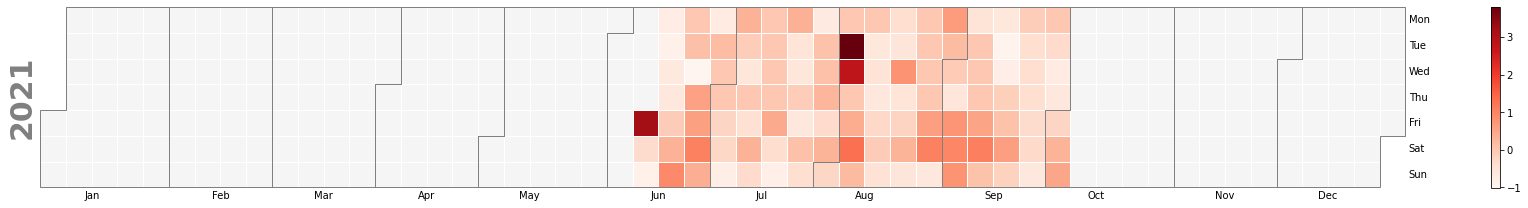

In [132]:
import calplot

calplot.calplot(df_date["z-score"], cmap = "Reds", figsize=(24,3))

In [88]:
b = df_date.groupby("date")[["z-score"]].mean().reset_index().rename({"z-score" : "value"}, axis = 1)
b["name"] = "z-score"
b.to_json("../json/z_score_by_time.json", orient='records')

In [82]:
df["time"].dt.strftime('%Y-%m-%d %s')

0       2021-06-11 00:00:00
1       2021-06-12 00:00:00
2       2021-06-13 00:00:00
3       2021-06-14 00:00:00
4       2021-06-15 00:00:00
               ...         
9594    2021-09-29 00:00:00
9595    2021-09-30 00:00:00
9596    2021-10-01 00:00:00
9597    2021-10-02 00:00:00
9598    2021-10-03 00:00:00
Name: time, Length: 9566, dtype: object

# ML?

In [28]:
training_df = df[["homeTeam", "awayTeam", "price", "ticket_count", "days_to_game",]].reset_index()
# training_df = df[["days_to_game", "z-score"]]
y = training_df["price"]
X = training_df.drop(["price", "index"], axis = 1)
# X["time"] = X["time"].dt.strftime('%Y-%m-%d')
X

,homeTeam,awayTeam,ticket_count,days_to_game
0,Los Angeles Dodgers,Texas Rangers,0,3
1,Los Angeles Dodgers,Houston Astros,0,56
2,Los Angeles Dodgers,Colorado Rockies,0,47
3,Los Angeles Dodgers,Colorado Rockies,0,46
4,Los Angeles Dodgers,Colorado Rockies,0,45
...,...,...,...,...
18825,San Francisco Giants,San Diego Padres,1956,1
18826,Los Angeles Dodgers,Milwaukee Brewers,1937,0
18827,San Francisco Giants,San Diego Padres,1679,0
18828,Los Angeles Dodgers,Milwaukee Brewers,1419,0


In [29]:
training_df.to_csv("training_df.csv")

In [31]:
from sklearn.preprocessing import OneHotEncoder
away_enc = OneHotEncoder(categories = "auto", sparse = False, handle_unknown = "ignore")
home_enc = OneHotEncoder(categories = "auto", sparse = False, handle_unknown = "ignore")
away_enc.fit(X["awayTeam"].to_numpy().reshape(-1, 1))
home_enc.fit(X["homeTeam"].to_numpy().reshape(-1, 1))
away_dummies = pd.DataFrame(away_enc.transform(X["awayTeam"].to_numpy().reshape(-1, 1)), columns = away_enc.get_feature_names(["away"]))
home_dummies = pd.DataFrame(home_enc.transform(X["homeTeam"].to_numpy().reshape(-1, 1)), columns = home_enc.get_feature_names(["home"]))
X = pd.concat([X, away_dummies, home_dummies], axis = 1).drop(["awayTeam", "homeTeam"], axis = 1)
X

,ticket_count,days_to_game,away_Arizona Diamondbacks,away_Atlanta Braves,away_Baltimore Orioles,away_Boston Red Sox,away_Chicago Cubs,away_Colorado Rockies,away_Detroit Tigers,away_Houston Astros,...,away_San Diego Padres,away_San Francisco Giants,away_Seattle Mariners,away_St. Louis Cardinals,away_Texas Rangers,away_Toronto Blue Jays,away_Washington Nationals,home_Los Angeles Angels,home_Los Angeles Dodgers,home_San Francisco Giants
0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,47,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,46,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,45,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18825,1956,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18826,1937,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18827,1679,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18828,1419,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [217]:
away_dummies = pd.get_dummies(X["awayTeam"], prefix = "awayTeam")
home_dummies = pd.get_dummies(X["homeTeam"], prefix = "homeTeam")
X = pd.concat([X, away_dummies, home_dummies], axis = 1).drop(["awayTeam", "homeTeam"], axis = 1)
X

,index,ticket_count,days_to_game,awayTeam_Arizona Diamondbacks,awayTeam_Atlanta Braves,awayTeam_Baltimore Orioles,awayTeam_Boston Red Sox,awayTeam_Chicago Cubs,awayTeam_Colorado Rockies,awayTeam_Detroit Tigers,...,awayTeam_San Diego Padres,awayTeam_San Francisco Giants,awayTeam_Seattle Mariners,awayTeam_St. Louis Cardinals,awayTeam_Texas Rangers,awayTeam_Toronto Blue Jays,awayTeam_Washington Nationals,homeTeam_Los Angeles Angels,homeTeam_Los Angeles Dodgers,homeTeam_San Francisco Giants
0,0,0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,2,0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,3,0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9561,9594,2693,77.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9562,9595,2666,78.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9563,9596,2825,79.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9564,9597,2940,80.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [222]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X, y)
LR.score(X, y)

0.61376283416149

In [32]:
from sklearn.feature_selection import f_classif
f_classif(X,y)

(array([16.00009635, 12.26363847,  8.69182128, 13.38471693,  3.71201771,
         1.97801555, 11.5457066 ,  6.71444788,  1.3749638 ,  6.92374497,
        11.86807841, 34.36824782,  7.43462925,  8.6591628 , 14.13761378,
         4.10858952, 27.09709855, 11.05238764, 11.66505063,  6.80344312,
         5.18301874,  2.04880526,  4.02406588, 10.99765945,  7.91247588,
        27.89648048, 24.72766953, 11.93183466]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.40367877e-295, 8.16319824e-068, 0.00000000e+000, 0.00000000e+000,
        8.11742403e-015, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.55416267e-075, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [243]:
home_team = "Los Angeles Dodgers"
away_team = "San Francisco Giants"
days_to_game = 0
ticket_count = 3000
predict = np.concatenate([np.array([days_to_game, ticket_count]), away_enc.transform(np.array([away_team]).reshape(1, -1)).ravel(), home_enc.transform(np.array([home_team]).reshape(1, -1)).ravel()])
LR.predict(predict.reshape(-1,1))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 28 is different from 1)

In [227]:
home_enc.transform(np.array(["Los Angeles Dodgers"]).reshape(1, -1))

array([[0., 1., 0.]])

In [240]:
away_enc.transform(np.array([away_team]).reshape(-1, 1)).ravel().shape

(23,)